# Untappd rating recalcuation

An attempt to recalculate beer ratings based the rating preferences of the individual users.

Since Untappd has a closed API, we do some limited scraping, which leads to very small rating data sets (at most 5 check ins per user and 20 per beer).

The approach should work just fine on larger data sets, possibly with another rescaling approach. The users' long-term rating tendencies should also be taken into account.

In [1]:
import hashlib
import pathlib
from collections.abc import Iterable, Sequence
from typing import NamedTuple
from urllib.parse import urljoin
from urllib.request import Request, urlopen

import numpy as np
import pandas as pd
import plotnine as p9
from bs4 import BeautifulSoup, Tag

## HTML fetching

Limited scraping is the best we can do without reinventing our own API.

In [2]:
USER_AGENT = 'Mozilla/5.0 (X11; Linux x86_64; rv:135.0) Gecko/20100101 Firefox/135.0'
HTML_CACHE_ROOT = pathlib.Path('html_cache')

UNTAPPD_BASE_URL = 'https://untappd.com'
USER_URL_PREFIX = '/user/'
BEER_URL_PREFIX = '/b/'


def caching_get(url: str) -> str:
    HTML_CACHE_ROOT.mkdir(exist_ok=True)
    whole_url = urljoin(UNTAPPD_BASE_URL, url)
    file_path = HTML_CACHE_ROOT / f'{whole_url.replace(':', '_').replace('/', '_')}.html'

    try:
        with open(file_path) as file:
            return file.read()
    except FileNotFoundError:
        pass

    req = Request(urljoin(UNTAPPD_BASE_URL, url))
    req.add_header('User-Agent', USER_AGENT)
    res = urlopen(req)
    html = res.read().decode('utf8')

    with open(file_path, 'w') as file:
        file.write(html)

    return html


def get_beer_html(beer_id: str) -> str:
    return caching_get(urljoin(BEER_URL_PREFIX, beer_id))


def get_user_html(user_id: str) -> str:
    return caching_get(urljoin(USER_URL_PREFIX, user_id))

## HTML parsing

We are only interested in rated beers.

In [3]:
user_id_to_name = dict[str, str]()
beer_id_to_name = dict[str, str]()


class CheckIn(NamedTuple):
    beer_id: str
    user_id: str
    rating: float


def iter_check_ins(soup: Tag) -> Iterable[CheckIn]:
    for check_in_tag in soup.find_all(class_='checkin'):
        user_tag = check_in_tag.find(class_='user')
        beer_tag = next(tag for tag in check_in_tag.find_all('a') if tag['href'].startswith(BEER_URL_PREFIX))
        rating_tag = check_in_tag.find(class_='caps')

        if user_tag is None or beer_tag is None or rating_tag is None:
            continue

        user_id = user_tag['href'][len(USER_URL_PREFIX):]
        user_id_to_name[user_id] = user_tag.string

        beer_id = beer_tag['href'][len(BEER_URL_PREFIX):]
        beer_img = beer_tag.find('img')

        if beer_img is not None:
            beer_id_to_name[beer_id] = beer_img['alt']

        rating = float(rating_tag['data-rating'])
        yield CheckIn(beer_id=beer_id, user_id=user_id, rating=rating)


def get_beer_check_ins(beer_id: str) -> Sequence[CheckIn]:
    beer_html = get_beer_html(beer_id)
    beer_soup = BeautifulSoup(beer_html)
    return list(iter_check_ins(beer_soup))


def get_user_check_ins(user_id: str) -> Sequence[CheckIn]:
    user_html = get_user_html(user_id)
    user_soup = BeautifulSoup(user_html)
    return list(iter_check_ins(user_soup))

## Rating evaluation

For every user, we take his available ratings and rescale them as $2.5 + (\xi - \hat\mu) / \hat\sigma$, where $\hat\mu$ and $\hat\sigma$ are estimates for the central tendency and deviation. The mean and standard deviation estimates did not lead to good results due to non-normality of the data, so the median and mean absolute deviation from it are used instead. This seems to bound most data between -2.5 and 2.5, and we add 2.5 so that the adjusted ratings are between $0$ and $5$.

For every beer, we rescale the rating of each user based on the above.

In [4]:
def adjust_rating(user_ratings: np.ndarray, rating: float) -> float:
    center = np.median(user_ratings)
    dispersion = np.mean(np.abs(user_ratings - center))

    # We don't really know what to do here...
    if abs(dispersion) < 1e-3:
        return rating

    return 2.5 + (rating - center) / np.sqrt(dispersion)


def get_user_ratings(user_id: str) -> np.ndarray:
    user_check_ins = get_user_check_ins(user_id)
    return np.array([c.rating for c in user_check_ins])


def plot_user_ratings(user_id: str) -> p9.ggplot:
    original_ratings = get_user_ratings(user_id)
    adjusted_ratings = np.array([adjust_rating(original_ratings, r) for r in original_ratings])

    df = pd.concat([
        pd.DataFrame({'rating': original_ratings, 'kind': 'Real rating'}),
        pd.DataFrame({'rating': adjusted_ratings, 'kind': 'Adjusted rating'})
    ])

    df['kind'] = df['kind'].astype('category').cat.reorder_categories(['Real rating', 'Adjusted rating'])

    return p9.ggplot(df, p9.aes(xmin=0, xmax=5, x='rating', color='kind', fill='kind')) \
        + p9.geom_density(alpha=0.5, show_legend=False) \
        + p9.labs(x='Rating', y='Density', title=f'{user_id_to_name[user_id]} (@{user_id})', subtitle=f'Based on {len(original_ratings)} ratings') \
        + p9.facet_wrap('kind', scales='free_y') \
        + p9.theme_minimal() \
        + p9.theme(figure_size=(8, 4))

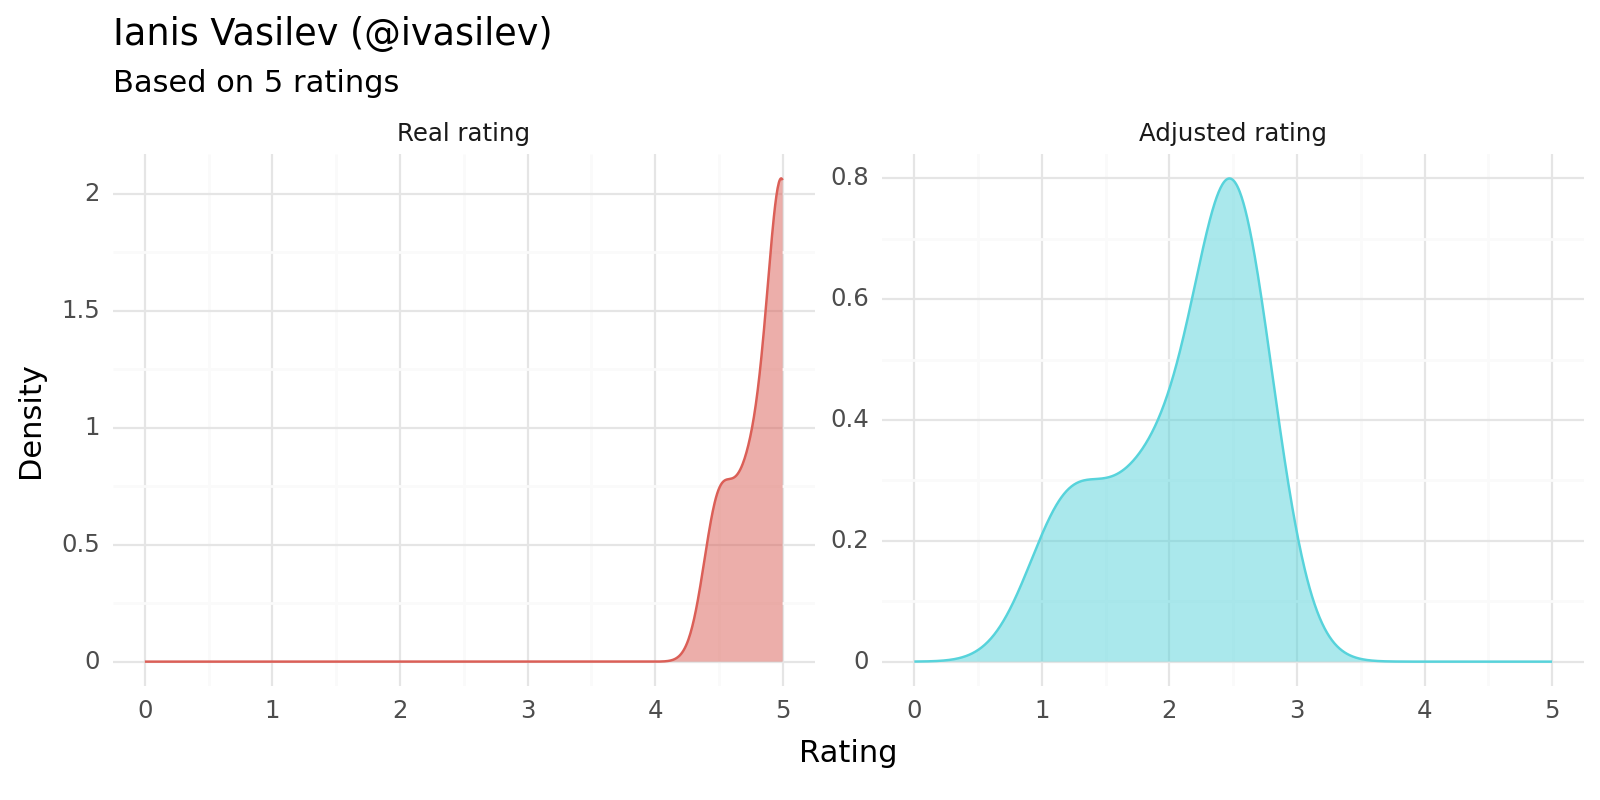

<Figure Size: (800 x 400)>

In [5]:
plot_user_ratings('ivasilev')

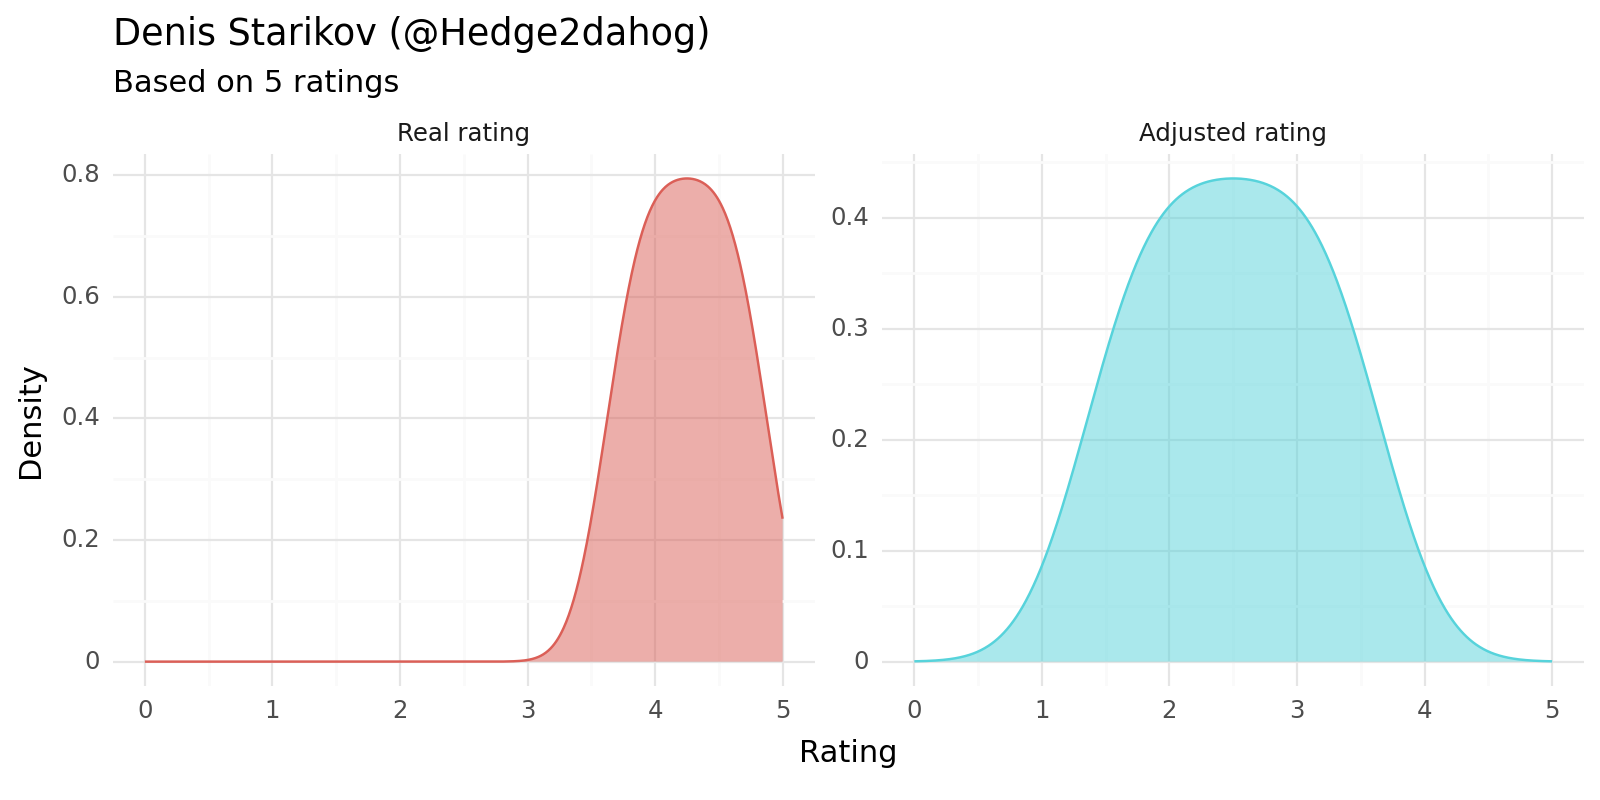

<Figure Size: (800 x 400)>

In [6]:
plot_user_ratings('Hedge2dahog')

In [7]:
def plot_beer_ratings(beer_id: str) -> p9.ggplot:
    beer_check_ins = get_beer_check_ins(beer_id)
    original_ratings = np.array([c.rating for c in beer_check_ins])
    adjusted_ratings = np.array([adjust_rating(get_user_ratings(c.user_id), c.rating) for c in beer_check_ins])

    df = pd.concat([
        pd.DataFrame({'rating': original_ratings, 'kind': 'Real rating'}),
        pd.DataFrame({'rating': adjusted_ratings, 'kind': 'Adjusted rating'})
    ])

    df['kind'] = df['kind'].astype('category').cat.reorder_categories(['Real rating', 'Adjusted rating'])

    return p9.ggplot(df, p9.aes(xmin=0, xmax=5, x='rating', color='kind', fill='kind')) \
        + p9.geom_density(alpha=0.5, show_legend=False) \
        + p9.labs(x='Rating', y='Density', title=f'{beer_id_to_name[beer_id]}', subtitle=f'Based on {len(original_ratings)} ratings') \
        + p9.facet_wrap('kind', scales='free_y') \
        + p9.theme_minimal() \
        + p9.theme(figure_size=(8, 4))

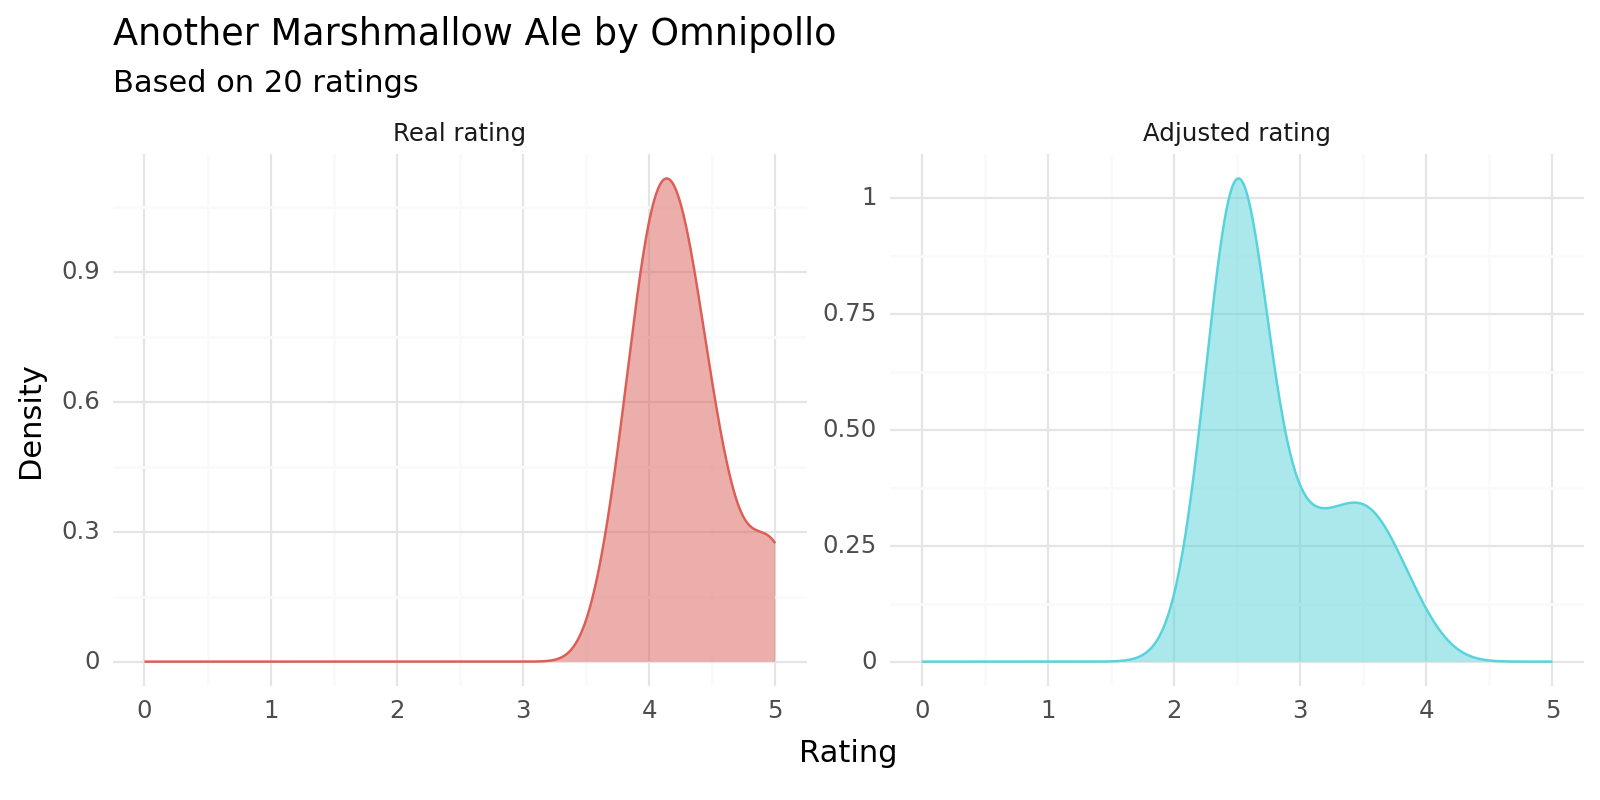

<Figure Size: (800 x 400)>

In [8]:
plot_beer_ratings('omnipollo-another-marshmallow-ale/6121304')

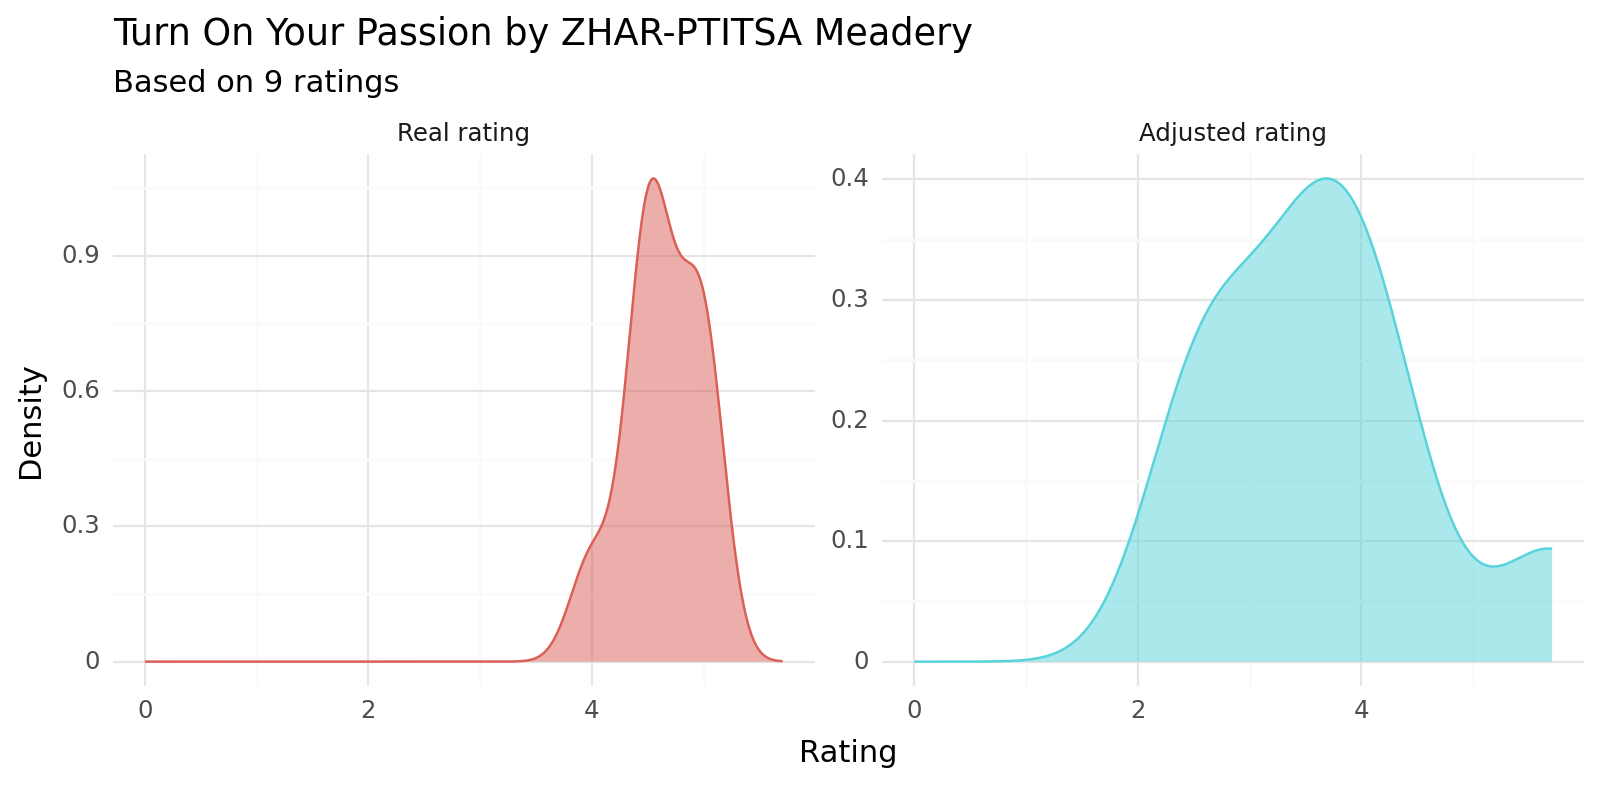

<Figure Size: (800 x 400)>

In [9]:
plot_beer_ratings('zhar-ptitsa-meadery-turn-on-your-passion/6172547')

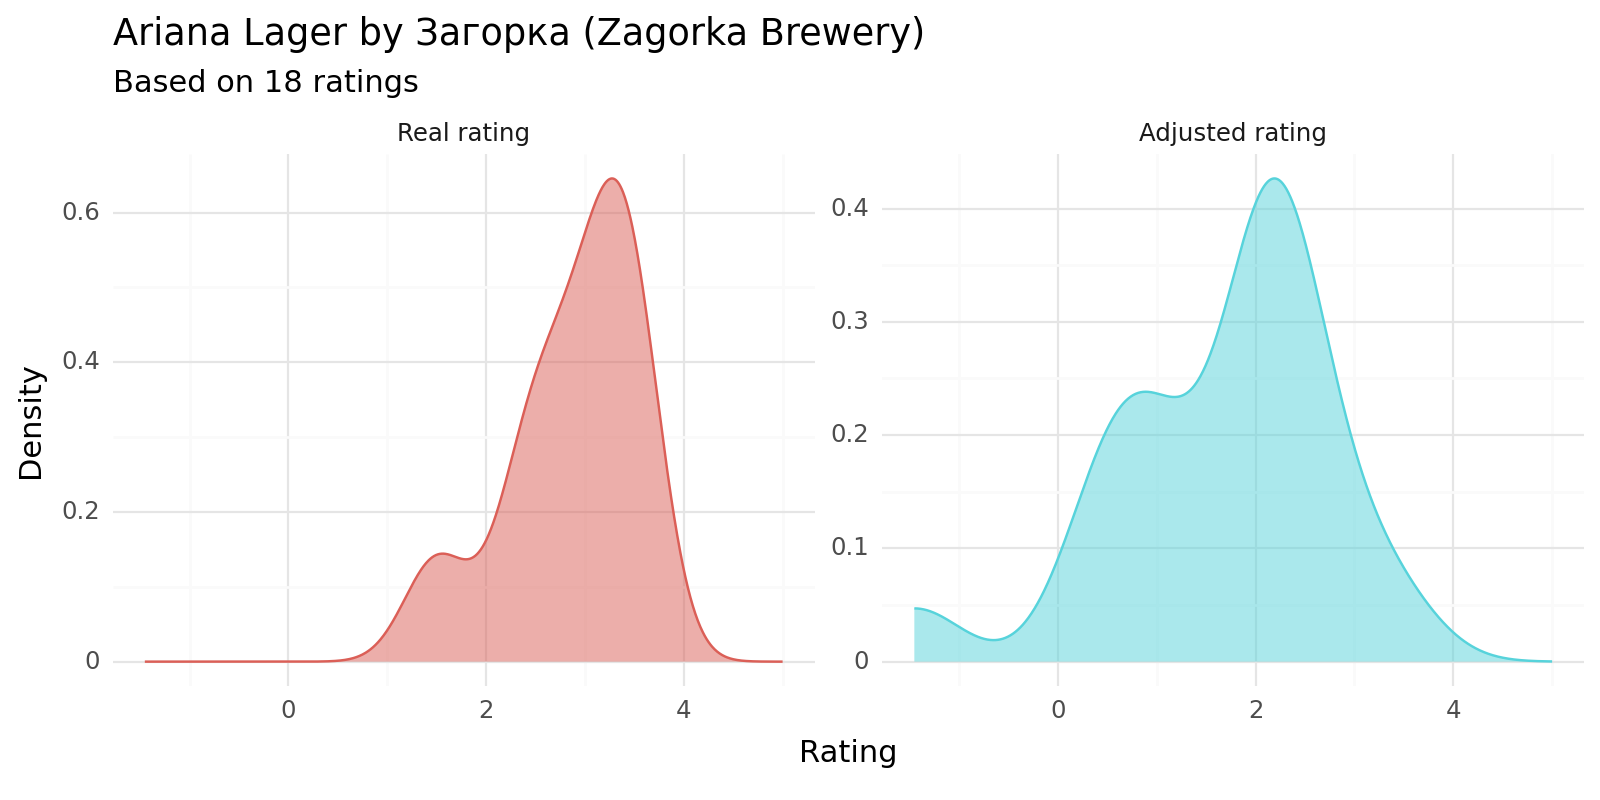

<Figure Size: (800 x 400)>

In [10]:
plot_beer_ratings('zagorka-zagorka-brewery-ariana-lager/21765')